# Ensemble

In [141]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "regression"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

import platform
from matplotlib import font_manager, rc

#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
import warnings
warnings.filterwarnings(action='ignore')

# 투표 기반 분류기

## 여러 분류기를 이용한 sklearn 의 투표 기반 분류기

In [142]:
# 데이터 생성
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# print(X[0:5]) # x는 2행
# print(y[0:5]) # y는 2개의 feature
#모델 생성 및 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [143]:
#평가 지표 확인
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### 간접 투표 방식으로 변경

In [144]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 배깅 과 페이스팅

In [145]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


### 간접 투표 방식

In [146]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


#### oob 평가

In [147]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

## RandomForest

### 배깅 과 랜덤 포리스트 분류기 비교

In [148]:
#배깅을 이용한 random forest 만들기
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [149]:
#random forest 분류기
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [150]:
print(np.sum(y_pred == y_pred_rf) / len(y_pred))

1.0


In [151]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

#n_estimators는 나무의 개수
#n_jobs는 모델 훈련을 할 때의 코어의 개수
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = forest.predict(X_test) 

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
tree_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(tree_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)            
print(tree_report)


print('accuracy:',(tree_matrix[0,0]+tree_matrix[1,1])/np.sum(tree_matrix))

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


[[106  19]
 [ 27  63]]


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       125
           1       0.77      0.70      0.73        90

    accuracy                           0.79       215
   macro avg       0.78      0.77      0.78       215
weighted avg       0.78      0.79      0.78       215

accuracy: 0.786046511627907


(-1.0, 9.0)

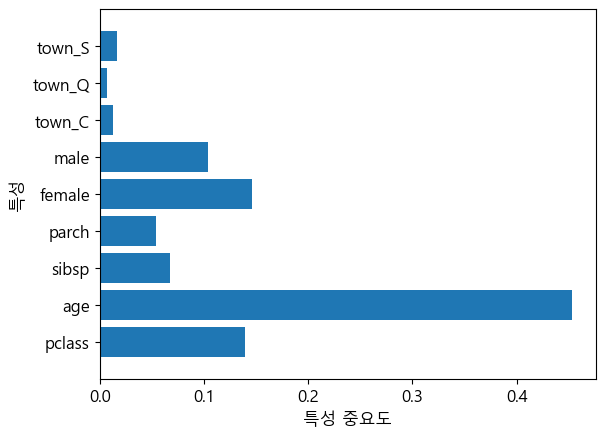

In [152]:
n_features = X.data.shape[1]
plt.barh(np.arange(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)

In [153]:
forest.feature_importances_  # 특성중요도지만 index 가 없어 알 수 없다.

array([0.13939992, 0.45307888, 0.06777061, 0.05378157, 0.14575955,
       0.1039795 , 0.0129322 , 0.00660981, 0.01668796])

# Boosting

## ada boost

In [154]:
# ada Boost
from sklearn.ensemble import AdaBoostClassifier
# algorithms 은 확률을 계산할 수 있으면 SAMME.R
# 없다면 SAMME
# learning Rate = 학습률
# 학습률이 너무 크면 최적화 되지 않을 확률이 높고 너무 작으면 훈련 속도가 너무 느려지게 된다.또한 overfitting 우려가 있다. 

ada_clf=AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)

y_hat=ada_clf.predict(X_test)
print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 0 1 0 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]


## Gradient Boosting

In [155]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(gb_pred[0:10])
print(y_test.values[0:10])


print('GBM 정확도: {0:.4f}'.format(gb_accuracy))


[0 1 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]
GBM 정확도: 0.7953


In [156]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 100}
최고 예측 정확도: 0.7896


In [157]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.8372


In [158]:
gbm_predict=metrics.classification_report(y_test,gb_pred)
print(gbm_predict)

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       125
           1       0.89      0.70      0.78        90

    accuracy                           0.84       215
   macro avg       0.85      0.82      0.83       215
weighted avg       0.84      0.84      0.83       215



## xgboost

#### 위스콘신 데이터에 xgboost 적용

In [159]:
from sklearn.datasets import load_breast_cancer

dataset=load_breast_cancer()

X_features=dataset.data
y_label=dataset.target

cancer_df=pd.DataFrame(data=X_features,columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,...,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,...,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,...,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,...,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,...,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,...,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [160]:
# 데이터의 분포 확인
# 데이터의 비율이 한쪽으로 치우치면 가중치를 적용하던가, 층화추출을 고려해보아야 한다. 
print(cancer_df['target'].value_counts())

1    357
0    212
Name: target, dtype: int64


In [161]:
# 학습 데이터와 훈련 데이터 분할.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.1,random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(512, 30) (57, 30)
(512,) (57,)


In [162]:
# xgboost 를 이용하는 경우의 데이터 생성
import xgboost as xgb

dtrain=xgb.DMatrix(data=X_train,label=y_train)
dtest=xgb.DMatrix(data=X_test,label=y_test)

In [163]:
# 하이퍼 파라미터
params={
	'max_depth':3,
	'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss'
}
num_rounds=400

In [164]:
# 훈련 데이터와 검증 데이터 생성. 
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , \
                      early_stopping_rounds=100, evals=wlist )

[0]	train-logloss:0.61037	eval-logloss:0.61558
[1]	train-logloss:0.54069	eval-logloss:0.54872
[2]	train-logloss:0.48296	eval-logloss:0.49537
[3]	train-logloss:0.43301	eval-logloss:0.44731
[4]	train-logloss:0.39087	eval-logloss:0.40909
[5]	train-logloss:0.35407	eval-logloss:0.37329
[6]	train-logloss:0.32249	eval-logloss:0.34289
[7]	train-logloss:0.29438	eval-logloss:0.31772
[8]	train-logloss:0.26826	eval-logloss:0.29340
[9]	train-logloss:0.24606	eval-logloss:0.27084
[10]	train-logloss:0.22697	eval-logloss:0.25421
[11]	train-logloss:0.20917	eval-logloss:0.23491
[12]	train-logloss:0.19273	eval-logloss:0.22002
[13]	train-logloss:0.17816	eval-logloss:0.20474
[14]	train-logloss:0.16588	eval-logloss:0.19562
[15]	train-logloss:0.15457	eval-logloss:0.18297
[16]	train-logloss:0.14389	eval-logloss:0.17189
[17]	train-logloss:0.13372	eval-logloss:0.15872
[18]	train-logloss:0.12512	eval-logloss:0.15291
[19]	train-logloss:0.11706	eval-logloss:0.14660
[20]	train-logloss:0.10976	eval-logloss:0.13897
[2

In [165]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
# 임계치를 정해서 해당 값보다 높으면 1로 판단, 낮으면 0으로 판단한다.
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.992 0.001 0.    1.    1.    0.    0.001 0.224 0.41  0.999]
예측값 10개만 표시: [1, 0, 0, 1, 1, 0, 0, 0, 0, 1]


In [166]:
# 평가 지표 확인
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.metrics import classification_report

confusion=confusion_matrix(y_test,preds)
print(confusion)

# 정확도
accuracy=accuracy_score(y_test,preds)
print(accuracy)

# 정밀도
precision=precision_score(y_test,preds)
print(precision)

# 재현율 - 실제 T 중 T로 판단한 개수
recall = recall_score(y_test,preds)
print(recall)

print(classification_report(y_test,preds))

# f1-score : 정밀도와 재현율의 조화 평균
f1=f1_score(y_test,preds)
print(f1)

[[16  1]
 [ 1 39]]
0.9649122807017544
0.975
0.975
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.97      0.97      0.97        40

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57

0.975


In [167]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[16  1]
 [ 1 39]]
정확도: 0.9649, 정밀도: 0.9750, 재현율: 0.9750,    F1: 0.9750, AUC:0.9926


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

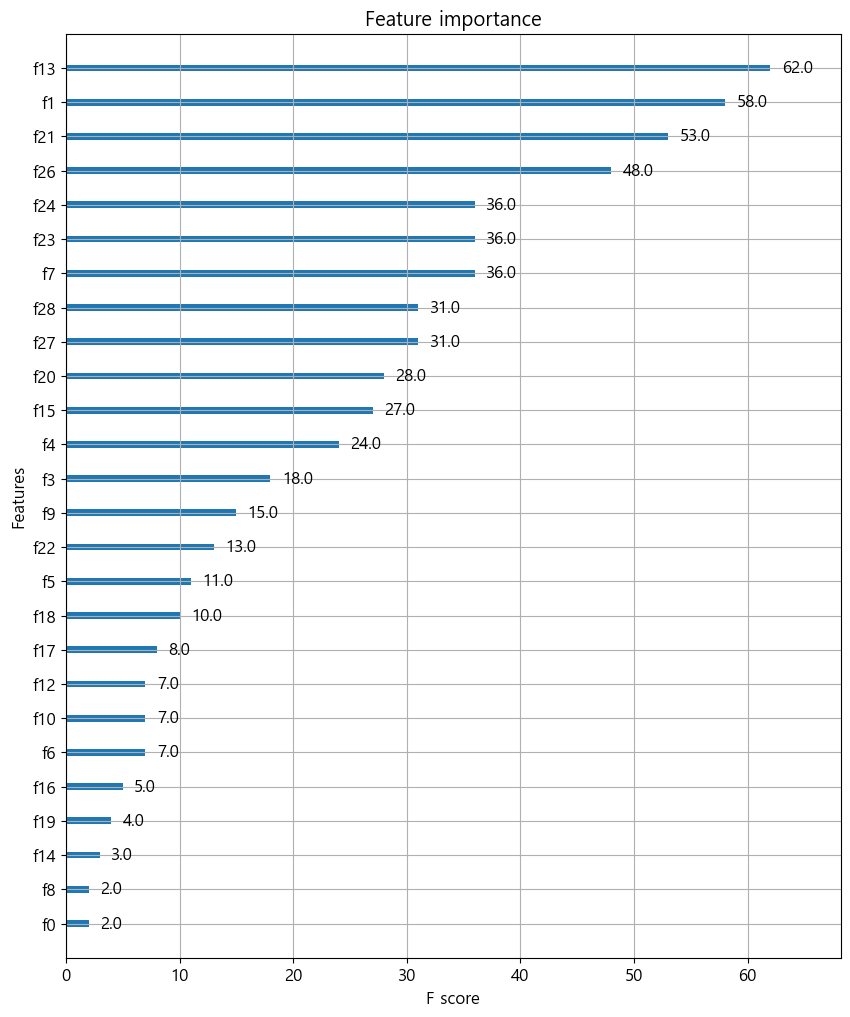

In [168]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

In [169]:
# 트리 기반이라 to_graphviz() API를 이용해 시각화 가능.
# cv() API를 이용해 교차 검증도 가능하다. 

# Light GBM

In [170]:
from lightgbm import LGBMClassifier

# 예측기의 개수를 400으로 해서 LightGBM모델 생성
lgbm_clf=LGBMClassifier(n_estimators=400)

# 평가 데이터 생ㅇ성
evals=[(X_test,y_test)]
lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)

[1]	valid_0's binary_logloss: 0.549362
[2]	valid_0's binary_logloss: 0.493936
[3]	valid_0's binary_logloss: 0.442048
[4]	valid_0's binary_logloss: 0.401232
[5]	valid_0's binary_logloss: 0.364737
[6]	valid_0's binary_logloss: 0.337392
[7]	valid_0's binary_logloss: 0.308468
[8]	valid_0's binary_logloss: 0.285292
[9]	valid_0's binary_logloss: 0.26444
[10]	valid_0's binary_logloss: 0.243656
[11]	valid_0's binary_logloss: 0.227468
[12]	valid_0's binary_logloss: 0.213536
[13]	valid_0's binary_logloss: 0.20074
[14]	valid_0's binary_logloss: 0.190849
[15]	valid_0's binary_logloss: 0.183704
[16]	valid_0's binary_logloss: 0.176076
[17]	valid_0's binary_logloss: 0.168509
[18]	valid_0's binary_logloss: 0.163211
[19]	valid_0's binary_logloss: 0.158848
[20]	valid_0's binary_logloss: 0.149449
[21]	valid_0's binary_logloss: 0.145378
[22]	valid_0's binary_logloss: 0.143931
[23]	valid_0's binary_logloss: 0.139705
[24]	valid_0's binary_logloss: 0.136737
[25]	valid_0's binary_logloss: 0.134318
[26]	valid_

LGBMClassifier(n_estimators=400)

In [171]:
preds = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]
print(preds)

[1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1]


In [172]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[16  1]
 [ 1 39]]
정확도: 0.9649, 정밀도: 0.9750, 재현율: 0.9750,    F1: 0.9750, AUC:0.9926


## Stacking

#### 위스콘신 유방암 데이터를 가지고 개별 훈련기와 stacking 의 차이를 학습한다. 

In [173]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)


In [174]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)

In [175]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [176]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [177]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [178]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


# Kaggle Data 분류하기
- 범주형 데이터를 구성된 피처를 이용한 이진 분류

In [179]:
train=pd.read_csv('./kaggle/cat-in-the-dat/train.csv',index_col='id')
train
train_y=train['target']
train_X=train.drop('target',axis=1)
print(train.shape)

(300000, 24)


In [180]:
test=pd.read_csv('./kaggle/cat-in-the-dat/test.csv',index_col='id')
test
# test_y=test['target']
# test_X=test.drop('target',axis=1)
# test_X
print(test.shape)

(200000, 23)


In [181]:
# 답안은 클래스가 아니고 확률로 제출한다.
submission=pd.read_csv('./kaggle/cat-in-the-dat/sample_submission.csv',index_col='id')
submission

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5
...,...
499995,0.5
499996,0.5
499997,0.5


In [182]:
# 피처의 정보요약 함수 생성
def resumtable(df):
	print('데이터의 구조 ',df.shape)
	summary=pd.DataFrame(df.dtypes,columns=['데이터 타입'])
	summary=summary.reset_index()
	summary=summary.rename(columns={'index':'feature'})
	summary['결측값 개수']=df.isnull().sum().values
	summary['고유값 개수']=df.nunique().values
	summary['첫번째 값']=df.loc[0].values
	summary['두번째 값']=df.loc[1].values
	summary['세번째 값']=df.loc[2].values
	return summary

In [183]:
resumtable(train)

데이터의 구조  (300000, 24)


,feature,데이터 타입,결측값 개수,고유값 개수,첫번째 값,두번째 값,세번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


In [184]:
for i in range(3):
	feature='ord_'+str(i)
	# 문자열이 아닌 데이터를 출력하고자 하는 경우. 
	print(feature+f'고유값: {train[feature].unique()}')

ord_0고유값: [2 1 3]
ord_1고유값: ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2고유값: ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


In [185]:
print('day 고유값:',train['day'].unique())

day 고유값: [2 7 5 4 3 1 6]


## 시각화를 이용한 데이터 탐색

[Text(0.5, 1.0, 'Target Distribution')]

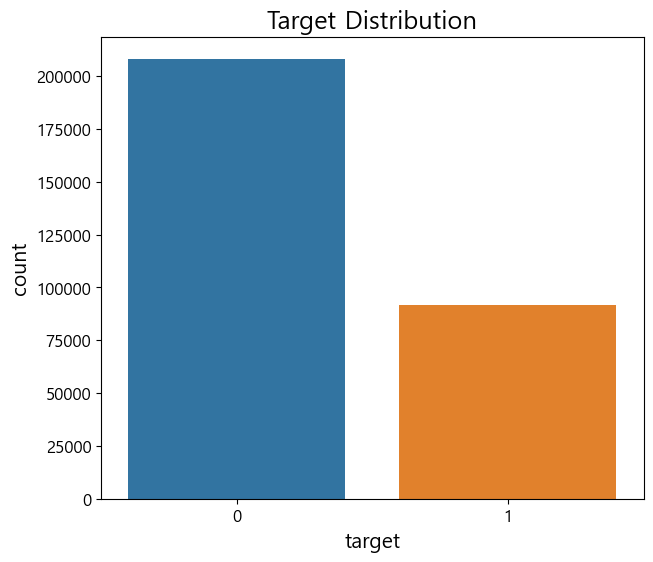

In [186]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rc('font',size=15)
plt.figure(figsize=(7,6))


# 타겟의 분포 확인
ax=sns.countplot(x='target',data=train)
ax.set(title='Target Distribution')

# 그래프 텍스트 출력
- 그래프에 텍스트를 출력할 때는 위치를 설정해서 출력
- 현재 화면에 그려진 그래프에 대한 정보를 알고자 하는 경우 ```ax.patches``` 속성 이용가능
- 막대 그래프의 경우 막대에 대한 정보가 ```patches``` 에 저장.
- 막대가 순서대로 0,1,2,3,4번 인덱스에 저장이 된다. 

In [187]:
# 첫번째 막대에 대한 정보를 확인
rectangle=ax.patches[0]

print('높이',rectangle.get_height())
print('너비',rectangle.get_width())
print('왼쪽 테두리의 x좌표',rectangle.get_x())

높이 208236.0
너비 0.8
왼쪽 테두리의 x좌표 -0.4


Text(0.5, 1.0, 'Target Distribution')

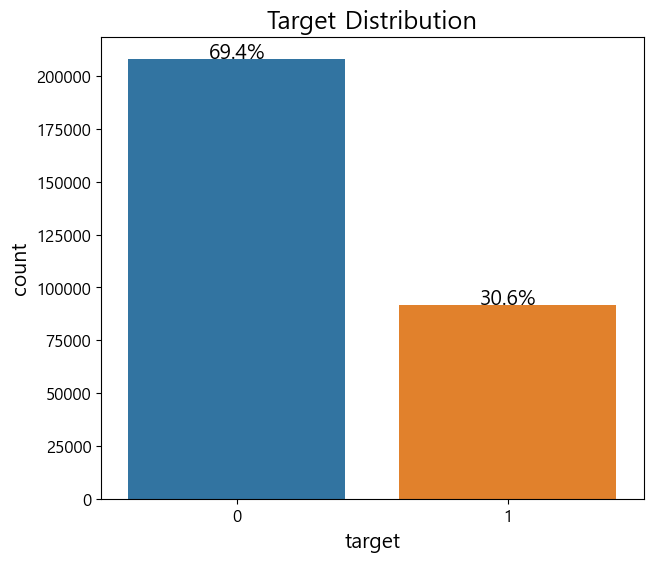

In [188]:
# 텍스트 출력 - 비율을 표시
def write_percent(ax,total_size):
	for patch in ax.patches:
		height=patch.get_height()
		width=patch.get_width()
		left_coord=patch.get_x()

		percent=height/total_size*100

		ax.text(x=left_coord+width/2.0,y=height+total_size*0.001,s=f'{percent:1.1f}%',ha='center')

plt.figure(figsize=(7,6))
ax=sns.countplot(x='target',data=train)
write_percent(ax,len(train))
ax.set_title('Target Distribution')

In [189]:
# 여러개의 이진 데이터 분포 확인
import matplotlib.gridspec as gridspec # 여러개의 이미지를 출력할 때 사용하는 격자

mpl.rc('font',size=12)
grid=gridspec.GridSpecBase(3,2) # 행,열
plt.figure(figsize=(10,16))
plt.subplots_adjust(wspace=0.4,hspace=0.3)

bin_features=['bin_0','bin_1','bin_2','bin_3','bin_4']

for idx,feature in enumerate(bin_features):
	ax=plt.subplot(grid[idx])
	sns.countplot(x=feature,data=train,hue='target',palette='pastel',ax=ax)
	ax.set_title(f'{feature} Distribution by Target')
	write_percent(ax,len(train))

AttributeError: 'NoneType' object has no attribute 'left'

<Figure size 1000x1600 with 0 Axes>

### 교차 분석 표

In [190]:
# Cross table
pd.crosstab(train['nom_0'],train['target'])


target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


In [191]:
# Cross table - 백분율로 보기
cross_tab=pd.crosstab(train['nom_0'],train['target'],normalize='index')*100

cross_tab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [192]:
# 인덱스를 일련번호로 수정
cross_tab=cross_tab.reset_index()
cross_tab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


In [193]:
# 교차 분석표를 생성하는 함수
def get_crosstab(df,feature):
	cross_tab=pd.crosstab(df[feature],df['target'],normalize='index')*100
	cross_tab=cross_tab.reset_index()
	return cross_tab
get_crosstab(train,'nom_0')

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


- 결측치가 없다.
- 피처의 의미를 알지 못하기 때문에 제거할수 없다.
## 데이터 전처리

In [194]:
# 순서형 인코딩의 자료형을 수정. 
# ord_n
print(train['ord_1'])



id
0         Grandmaster
1         Grandmaster
2              Expert
3         Grandmaster
4         Grandmaster
             ...     
299995    Contributor
299996         Novice
299997         Novice
299998         Master
299999    Contributor
Name: ord_1, Length: 300000, dtype: object


In [195]:
# ord1 은 novice,contirbutor,expert ,master, grandmaster 순으로 카테고리를 설정
# ord_2는 Freezing,cold,warn,hot,boiling Hot,Lava Hot 순으로 카테고리를 설정

from pandas.api.types import CategoricalDtype

ord_1_value=['Novice','Contirbutor','Expert' ,'Master', 'Grandmaster']
ord_2_value=[ 'Freezing','Cold','Warm','Hot','Boiling Hot','Lava Hot']

# 문자열 list를 타입으로 생성 - enum
ord_1_dtype=CategoricalDtype(categories=ord_1_value,ordered=True)
ord_2_dtype=CategoricalDtype(categories=ord_2_value,ordered=True)


train['ord_1']=train['ord_1'].astype(ord_1_dtype)
train['ord_2']=train['ord_2'].astype(ord_2_dtype)


## 기본 모델링

In [217]:
## 전처리
# 훈련 데이터와 테스트 데이터를 합친다.
all_data=pd.concat([train,test])
all_data=all_data.drop('target',axis=1)
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,...,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,...,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,...,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,...,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,...,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,...,Grandmaster,Freezing,a,R,qP,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,F,N,Green,Square,...,Novice,Lava Hot,j,A,Gb,1,3
499996,1,0,0,F,Y,Green,Trapezoid,...,Contributor,Lava Hot,f,S,Ed,2,2
499997,0,1,1,T,Y,Green,Trapezoid,...,Novice,Boiling Hot,g,V,TR,3,1


In [218]:
# 범주형 데이터를 원핫인코딩을 진행한다.
from sklearn.preprocessing import OneHotEncoder

encoder=OneHotEncoder()
all_data_encoded=encoder.fit_transform(all_data)

In [219]:
# 훈련 데이터와 테스트 데이터 분리
num_train=len(train)
X_train=all_data_encoded[:num_train]
X_test=all_data_encoded[num_train:]
y=train['target']

In [220]:
# 훈련에 사용할 데이터와 validation set 을 위한 데이터 분리
from sklearn.model_selection import train_test_split

# 층화 추출을 통해 테스트데이터와 검증용 데이터 생성
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y,test_size=0.1,random_state=42,stratify=y)

## 모델 생성 및 훈련\

In [221]:
# 이진 분류 이므로 모든 분류기 사용 가능
from sklearn.linear_model import LogisticRegression

# 모델 생성
logistic_model=LogisticRegression(max_iter=1000,random_state=123)
# 훈련
logistic_model.fit(X_train,y_train)


LogisticRegression(max_iter=1000, random_state=123)

In [222]:
logistic_model.predict(X_valid)

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [223]:
logistic_model.predict_proba(X_valid)

array([[0.6135743 , 0.3864257 ],
       [0.87985541, 0.12014459],
       [0.44565163, 0.55434837],
       ...,
       [0.94715845, 0.05284155],
       [0.91200368, 0.08799632],
       [0.36084552, 0.63915448]])

### 평가 지표

In [224]:
# 평가 지표
y_valid_preds=logistic_model.predict_proba(X_valid)[:,1]
#roc_auc
from sklearn.metrics import roc_auc_score

roc_auc=roc_auc_score(y_valid,y_valid_preds)
print('평가점수',roc_auc)


평가점수 0.7949633345067274


In [225]:
# 제출할 결과 파일 생성
y_preds=logistic_model.predict_proba(X_test)[:,1]
submission['target']=y_preds

submission.to_csv('submission.csv')

- kaggle에 제출
public score  : 대회 진행중 test데이터 가지고 수행한 점수
private score : test데이터가 아닌거 가지고 수행한 결과 - 대회 진행중에는 공개 안됨.

# 모델 수정

In [226]:
# 데이터 확인
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,...,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,...,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,...,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,...,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,...,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,...,Grandmaster,Freezing,a,R,qP,7,8


In [227]:
# 이진 피처 인코딩을 수정
# 숫자가 아닌 데이터를 숫자로 변환
# 문자로 되어있는 경우 숫자로 수정하는것이 좋다.
all_data['bin3']=all_data['bin_3'].map({'F':0,'T':1})
all_data['bin4']=all_data['bin_4'].map({'N':0,'Y':1})

print(all_data.head())

    bin_0  bin_1  bin_2 bin_3 bin_4  nom_0      nom_1  ... ord_3 ord_4 ord_5  \
id                                                     ...                     
0       0      0      0     T     Y  Green   Triangle  ...     h     D    kr   
1       0      1      0     T     Y  Green  Trapezoid  ...     a     A    bF   
2       0      0      0     F     Y   Blue  Trapezoid  ...     h     R    Jc   
3       0      1      0     F     Y    Red  Trapezoid  ...     i     D    kW   
4       0      0      0     F     N    Red  Trapezoid  ...     a     R    qP   

   day month bin3 bin4  
id                      
0    2     2    1    1  
1    7     8    1    1  
2    7     2    0    1  
3    2     1    0    1  
4    7     8    0    0  

[5 rows x 25 columns]


In [228]:
# 순서형 피처 인코딩을 수정
ord1dict={}
ord2dict={}

ord_1_value=['Novice','Contirbutor','Expert' ,'Master', 'Grandmaster']
ord_2_value=[ 'Freezing','Cold','Warm','Hot','Boiling Hot','Lava Hot']

for idx,val in enumerate(ord_1_value):
	ord1dict[val]=idx

for idx,val in enumerate(ord_2_value):
	ord2dict[val]=idx

In [229]:
print(ord1dict)

print(ord2dict)

{'Novice': 0, 'Contirbutor': 1, 'Expert': 2, 'Master': 3, 'Grandmaster': 4}
{'Freezing': 0, 'Cold': 1, 'Warm': 2, 'Hot': 3, 'Boiling Hot': 4, 'Lava Hot': 5}


In [230]:

all_data['ord_1']=all_data['ord_1'].map(ord1dict)
all_data['ord_2']=all_data['ord_2'].map(ord2dict)

In [231]:
# ord_3,4,5 눈 순서가 있는 범주형 이므로 원핫인코딩 대신 ordinal encoding을 수행한다. 

from sklearn.preprocessing import OrdinalEncoder

ord_345=['ord_3','ord_4','ord_5']
ord_encoder=OrdinalEncoder()

all_data[ord_345]=ord_encoder.fit_transform(all_data[ord_345])

for feature,categories in zip(ord_345,ord_encoder.categories_):
	print(feature)
	print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

In [232]:
# 명목형 목록 인코딩

nom_features=['nom_'+str(i) for i in range(10)]

from sklearn.preprocessing import OneHotEncoder

ohe=OneHotEncoder()
enccoded_nom_matrix=ohe.fit_transform(all_data[nom_features])
all_data=all_data.drop(nom_features,axis=1)

print(all_data)

        bin_0  bin_1  bin_2 bin_3 bin_4  ord_0  ord_1  ord_2  ord_3  ord_4  \
id                                                                           
0           0      0      0     T     Y      2    4.0      1    7.0    3.0   
1           0      1      0     T     Y      1    4.0      3    0.0    0.0   
2           0      0      0     F     Y      1    2.0      5    7.0   17.0   
3           0      1      0     F     Y      1    4.0      4    8.0    3.0   
4           0      0      0     F     N      1    4.0      0    0.0   17.0   
...       ...    ...    ...   ...   ...    ...    ...    ...    ...    ...   
499995      0      0      0     F     N      1    0.0      5    9.0    0.0   
499996      1      0      0     F     Y      1    NaN      5    5.0   18.0   
499997      0      1      1     T     Y      1    0.0      4    6.0   21.0   
499998      1      0      0     T     Y      2    4.0      4    6.0   23.0   
499999      0      0      0     T     Y      2    0.0      0   1

### 날짜 목록 인코딩

In [233]:
date_features=['day','month']
encoded_date_matrix=ord_encoder.fit_transform(all_data[date_features])
all_data=all_data.drop(date_features,axis=1)
print(encoded_date_matrix)

[[1. 1.]
 [6. 7.]
 [6. 1.]
 ...
 [2. 0.]
 [1. 0.]
 [1. 1.]]


In [234]:
# 순서형 목록은 스케일링 - 0~1 사이 min-max

from sklearn.preprocessing import MinMaxScaler

ord_features=['ord_'+str(i) for i in range(6)]
all_data[ord_features]=MinMaxScaler().fit_transform(all_data[ord_features])
all_data[ord_features]

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,
0,0.5,1.0,0.2,0.500000,0.12,0.712042
1,0.0,1.0,0.6,0.000000,0.00,0.486911
2,0.0,0.5,1.0,0.500000,0.68,0.162304
3,0.0,1.0,0.8,0.571429,0.12,0.701571
4,0.0,1.0,0.0,0.000000,0.68,0.827225
...,...,...,...,...,...,...
499995,0.0,0.0,1.0,0.642857,0.00,0.130890
499996,0.0,NaN,1.0,0.357143,0.72,0.089005
499997,0.0,0.0,0.8,0.428571,0.84,0.345550


In [236]:
# 인코딩한 데이터와 스케일링 한 데이터 합치기
from scipy import sparse

all_data_sprs=sparse.hstack([sparse.csr_matrix(all_data),
encoded_nom_matrix,
encoded_date_matrix],
format='csr')

all_data_sprs

TypeError: no supported conversion for types: (dtype('O'),)

## Hyper parameter tuning

In [1]:
from sklearn.model_selection import GridSearchCV

In [2]:
logistic_model=LogisticRegression()
lr_params={
	'C':[0.1,0.125,0.2],
	'max_iter':[800,900,1000],
	'solver':['libnear'],
	'random_state':[42]
}

grid_logistic=GridSearchCV(estimator=logistic_model,
						   params_grid=lr_params,
						   scoring='roc_auc',
						   cv=5)

grid_logistic.fit(X_train,y_train)
print(grid_logistic.best_params_)

NameError: name 'LogisticRegression' is not defined